# Models for Genomic Skipped Exon Events

In [41]:
%matplotlib inline
from keras.models import Sequential, model_from_json
from keras.layers import Convolution1D, LSTM, GRU, Dense, Activation, Dropout, MaxPooling1D, Embedding, BatchNormalization
from keras.objectives import binary_crossentropy, categorical_crossentropy
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.preprocessing import sequence

import sys
import os
sys.path.append(os.path.abspath('../src/'))
import nn_utils
reload(nn_utils)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.cross_validation import train_test_split

import tqdm

## Loading Genomic Data

In [5]:
import sqlite3

def reverse_complement(seq):
    complements = {'A':'T', 'T':'A', 'G':'C', 'C':'G', 'N':'N'}
    new_seq = [complements[bp] for bp in reversed(seq)]
    return ''.join(new_seq)

def lookup_A5(chrom, pos):
    """
    Given a position, finds all events that contain an alternative exon that includes the given position.
    Returns a list of events - list of tuples 
    (event_id, gene_id, alt_exon_start, alt_exon_end, chrom, strand, baseline_psi)
    """
    conn = sqlite3.connect('../../alternative_splicing_snp_prediction/data/alt_5_gtex.db')
    cur = conn.cursor()
    # leaving a
    cur.execute("SELECT * FROM alt_5 WHERE chrom=? AND alt_exon_start < ? AND alt_exon_end > ?;",
                (chrom, pos+3, pos-6))
    results = cur.fetchall()
    return results

def lookup_SE(chrom, pos):
    """
    Given a position, finds all events that contain an alternative exon that includes the given position.
    Returns a list of events - list of tuples 
    (event_id, gene_id, alt_exon_start, alt_exon_end, chrom, strand, baseline_psi)
    """
    conn = sqlite3.connect('./../alternative_splicing_snp_prediction/data/skipped_exon_gtex.db')
    cur = conn.cursor()
    # leaving a
    cur.execute("SELECT * FROM skipped_exon WHERE chrom=? AND alt_exon_start < ? AND alt_exon_end > ?;",
                (chrom, pos+3, pos-6))
    results = cur.fetchall()
    return results

def lookup_sequence_db(event_id, cur):
    """
    Given an event id (alt_5 or skipped exon), finds the alternative exon
    corresponding to that event.
    """
    cur.execute('SELECT seq FROM exons WHERE event_id=?', (event_id,))
    results = cur.fetchone()
    return results[0]

In [6]:
def extract_se_data():
    conn = sqlite3.connect('../../alternative_splicing_snp_prediction/data/skipped_exon_gtex.db')
    cur = conn.cursor()
    cur.execute('SELECT * FROM skipped_exon;')
    data_out = []
    conn2 = sqlite3.connect('../../alternative_splicing_snp_prediction/data/alt_exons.db')
    cur2 = conn2.cursor()
    for e in cur.fetchall():
        event_id = e[0]
        gene = e[1]
        start = e[2]
        end = e[3]
        strand = e[5]
        seq = lookup_sequence_db(event_id, cur2)
        if strand==0:
            seq = reverse_complement(seq)
        wt_psi = e[6]
        data_out.append((event_id, seq, wt_psi))
    return data_out

In [7]:
data = extract_se_data()

In [8]:
import pickle
pickle.dump(data, open('../data/se_data.pkl', 'w'))

In [26]:
genomic_exons = [c[1] for c in data]
genomic_exons_encoded = [nn_utils.seq_to_array(s) for s in genomic_exons]
actual = [c[2] for c in data]
new_actual = []
new_g = []
max_len = 200
min_len = 100
for a, g in zip(actual, genomic_exons_encoded):
    if a!=None and a>0 and a<1 and len(g)<=max_len and len(g) >= min_len:
        new_actual.append(a)
        new_g.append(g)

In [27]:
len(new_g)

17469

In [28]:
new_g2 = map(lambda x: np.rollaxis(sequence.pad_sequences(np.rollaxis(x, 1), max_len), 1), new_g)
new_g2 = np.dstack(new_g2)

In [29]:
new_g2.shape

(200, 4, 17469)

In [30]:
new_g2 = np.rollaxis(new_g2, 2)

In [31]:
G_train, G_test, P_train, P_test = train_test_split(new_g2, new_actual, test_size=0.2, random_state=0)

## Constructing Model

In [15]:
num_filters = [64,64,32]
filter_length = [6,6,6]


model2 = Sequential()
model2.add(GRU(num_filters[0], input_dim=4, return_sequences=True))
model2.add(Dropout(0.25))
model2.add(GRU(output_dim=num_filters[-1]))
model2.add(Dense(output_dim=1, activation='linear'))
model2.add(Activation('sigmoid'))

In [16]:
model2.compile(loss='binary_crossentropy',
              optimizer='adam')

In [32]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

model2.fit(G_train, P_train,
          nb_epoch=50,
          batch_size=500,
          show_accuracy=True,
          validation_data=(G_test, P_test),
          callbacks=[early_stopping])

Train on 13975 samples, validate on 3494 samples
Epoch 1/50
13975/13975 [==============================] - 82s - loss: 0.6923 - acc: 1.0000 - val_loss: 0.6918 - val_acc: 1.0000
Epoch 2/50
13975/13975 [==============================] - 85s - loss: 0.6922 - acc: 1.0000 - val_loss: 0.6916 - val_acc: 1.0000
Epoch 3/50
13975/13975 [==============================] - 84s - loss: 0.6920 - acc: 1.0000 - val_loss: 0.6915 - val_acc: 1.0000
Epoch 4/50
13975/13975 [==============================] - 88s - loss: 0.6918 - acc: 1.0000 - val_loss: 0.6914 - val_acc: 1.0000
Epoch 5/50
13975/13975 [==============================] - 90s - loss: 0.6919 - acc: 1.0000 - val_loss: 0.6912 - val_acc: 1.0000
Epoch 6/50
13975/13975 [==============================] - 89s - loss: 0.6921 - acc: 1.0000 - val_loss: 0.6911 - val_acc: 1.0000
Epoch 7/50
13975/13975 [==============================] - 89s - loss: 0.6920 - acc: 1.0000 - val_loss: 0.6910 - val_acc: 1.0000
Epoch 8/50
13975/13975 [==============================]

In [33]:
predictions = model2.predict(G_test)

In [34]:
r2_score(P_test, predictions)

0.015368763380585237

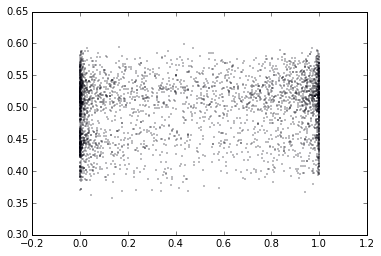

In [35]:
plt.scatter(P_test, predictions, s=0.1)

## Embedding Model

In [36]:
# why??? because i suck at this...
def seq_to_ints(seq):
    result = []
    for s in seq:
        if s=='A':
            result.append(1)
        if s=='T':
            result.append(2)
        if s=='C':
            result.append(3)
        if s=='G':
            result.append(4)
    return result

In [37]:
genomic_exons = [c[1] for c in data]
genomic_exons_encoded = [seq_to_ints(s) for s in genomic_exons]
actual = [c[2] for c in data]
new_actual = []
new_g = []
max_len = 400
min_len = 20
for a, g in zip(actual, genomic_exons_encoded):
    if a!=None and a>0 and a<1 and len(g)<=max_len and len(g) >= min_len:
        new_actual.append(a)
        new_g.append(g + [0]*(max_len - len(g)))

In [38]:
new_g2 = np.array(new_g)
new_actual = np.array(new_actual)

In [39]:
G_train, G_test, P_train, P_test = train_test_split(new_g2, new_actual, test_size=0.2, random_state=0)

In [42]:
num_filters = [64,64,32]
filter_length = [6,6,6]

model2 = Sequential()
model2.add(Embedding(input_dim=5, output_dim=2, mask_zero=True))
model2.add(GRU(output_dim=num_filters[0], return_sequences=True))
#model2.add(BatchNormalization())
model2.add(Dropout(0.25))
model2.add(GRU(output_dim=num_filters[1], return_sequences=True))
#model2.add(BatchNormalization())
model2.add(Dropout(0.25))
model2.add(GRU(output_dim=num_filters[-1]))
model2.add(BatchNormalization())
model2.add(Dense(output_dim=1, activation='linear'))
model2.add(Activation('sigmoid'))

In [43]:
model2.compile(loss='binary_crossentropy',
              optimizer='adam')

In [44]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

model2.fit(G_train, P_train,
          nb_epoch=50,
          batch_size=500,
          show_accuracy=True,
          validation_data=(G_test, P_test),
          callbacks=[early_stopping])

Train on 25853 samples, validate on 6464 samples
Epoch 1/50
25853/25853 [==============================] - 643s - loss: 0.6921 - acc: 1.0000 - val_loss: 0.6921 - val_acc: 1.0000
Epoch 2/50
20500/25853 [======================>.......] - ETA: 118s - loss: 0.6917 - acc: 1.0000

KeyboardInterrupt: 

In [28]:
G_train.shape

(22780, 200)

In [38]:
P_train.shape

(22780,)